In [1]:
import glob
import numpy as np
import pandas as pd
import cv2
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize
from scipy.signal import butter, filtfilt
from skimage.transform import resize
import datetime
from typing import List, Sequence, Tuple, Optional, Any
from matplotlib.axes import Axes

CONFIG = {
    'target_files': [
        'train_data/091222.npy',
        'train_data/090532.npy',
        'train_data/092722.npy',
    ],

    'dx': 5.106500953873407,
    'dt': 0.0016,

    'img_shape': (400, 400),
    'bands': [(10, 15), (80, 120), (160, 215)],

    'hough_params': {
        'rho': 1,
        'theta': np.pi/180,
        'threshold': 80,
        'minLineLength': 300,
        'maxLineGap': 75
    },

    'merge_params': {
        'angle_thresh': 0.08,
        'center_thresh': 28,
    }
}

In [2]:
def load_data(dir: str = 'train_data/') -> List[str]:
    files = glob.glob(dir+"*")
    files.sort()
    return files


def find_id_by_filename(starting_fname: str, files: list[str]) -> int | None:
    first_id = None
    for idx, fname in enumerate(files):
        if fname == starting_fname:
            first_id = idx
    return first_id


def retrieve_sensor_data(fname: str, files: list[str], dx: float = 5.106500953873407, dt: float = 0.0016) -> np.ndarray:
    starting_file_id = find_id_by_filename(fname, files)
    if starting_file_id is None:
        return None
    data = []
    for file in files[starting_file_id:starting_file_id+12]:
        data.append(np.load(file))
    data = np.concatenate(data).astype(np.float32)

    time_start = datetime.datetime.strptime(
        '2024-05-07 ' + fname.split("/")[-1].split(".")[0], "%Y-%m-%d %H%M%S")
    index = pd.date_range(start=time_start, periods=len(data), freq=f'{dt}s')

    columns = np.arange(len(data[0])) * dx
    return pd.DataFrame(data, index=index, columns=columns)


def plot_fft(df: pd.DataFrame, col_id: int, dt: float, xlim: int = 300, ax: Axes | None = None) -> None:
    """Plot FFT spectrum at a spatial position on a specific axis."""
    if ax is None:
        ax = plt.gca()

    spatial_pos = df.columns[col_id]
    signal = df[spatial_pos].values
    fft_result = np.fft.fft(signal)
    fft_freqs = np.fft.fftfreq(len(signal), d=dt)
    pos_freqs = fft_freqs[:len(signal)//2]
    pos_mags = np.abs(fft_result[:len(signal)//2])

    ax.plot(pos_freqs, pos_mags)
    ax.set_xlabel('Frequency [Hz]')
    ax.set_ylabel('Amplitude')
    ax.set_title(f'Spectrum at {spatial_pos:.1f} m')
    ax.set_xlim(0, xlim)
    ax.set_xticks(np.arange(0, xlim+10, 10))
    ax.tick_params(axis='x', rotation=45)


def plot_average_freq_spectrum(filtered_df: pd.DataFrame, dt: float, col_start: Optional[int] = None, col_end: Optional[int] = None, ax: Optional[Axes] = None) -> None:
    """Plots the average frequency spectrum of range of positions"""
    if ax is None:
        ax = plt.gca()

    avg_signal = filtered_df.iloc[:, col_start:col_end].mean(axis=1).values
    fft_result = np.fft.fft(avg_signal)
    fft_freqs = np.fft.fftfreq(len(avg_signal), d=dt)
    positive_freqs = fft_freqs[:len(avg_signal)//2]
    positive_mags = np.abs(fft_result[:len(avg_signal)//2])

    ax.plot(positive_freqs, positive_mags, color='orange')
    ax.set_xlabel("Frequency [Hz]")
    ax.set_ylabel("Amplitude")
    title_substring = "all" if col_start is None else f"{col_start}-{col_end}"
    ax.set_title(f"Avg Spectrum ({title_substring})")

def apply_band_filters(df: pd.DataFrame, bands, dt, order=4) -> pd.DataFrame:
    """
    Filter a DataFrame so that only the given bands are present (sum their filters).
    """
    fs = 1 / dt
    data = df.to_numpy()
    result = np.zeros_like(data)

    for low, high in bands:
        nyq = 0.5 * fs
        low_norm = low / nyq
        high_norm = high / nyq

        b, a = butter(order, [low_norm, high_norm], btype='band')
        result += filtfilt(b, a, data, axis=0)

    return pd.DataFrame(result, index=df.index, columns=df.columns)


def preprocess_df(df: pd.DataFrame) -> pd.DataFrame:
    data = df.to_numpy(dtype=np.float32)

    new_shape = (400, 400)
    start = df.index[0]
    end = df.index[-1]
    new_times = pd.date_range(start, end, periods=new_shape[0])
    data = resize(data, new_shape, anti_aliasing=True)
    data = cv2.normalize(data, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    processed_df = pd.DataFrame(data, index=new_times)
    return processed_df


def find_edges(df: pd.DataFrame) -> pd.DataFrame:
    data = df.to_numpy(dtype=np.uint8)
    bins = np.array([0, 4, 16, 32, 64, 128, 192, 256])
    quantized = np.digitize(data, bins) - 1
    quantized_img = quantized * (255 // (len(bins) - 1))

    return quantized_img.astype(np.uint8)


def plot_hough_lines(
    img: np.ndarray,
    lines: Optional[np.ndarray],
    speed_arr: Optional[np.ndarray],
    norm: Normalize,
    title: str = "",
    ax: Axes | None = None
) -> None:
    ax.imshow(img, cmap='viridis', aspect='auto', norm=norm)
    if lines is not None and speed_arr is not None:
        for line, speed in zip(lines, speed_arr):
            x1, y1, x2, y2 = line
            ax.plot([x1, x2], [y1, y2], color='r', linewidth=1)
            xm, ym = (x1 + x2) / 2, (y1 + y2) / 2
            ax.text(xm, ym, f"{speed:.1f} km/h", color='yellow', fontsize=8, va='center',
                    ha='center', bbox=dict(facecolor='black', alpha=0.5, edgecolor='none'))
    ax.set_title(title)
    ax.axis('off')


def filter_vertical_lines(
    lines: Sequence[Tuple[float, float, float, float]],
    angle_threshold: float = 10
) -> List[Tuple[float, float, float, float]]:
    """
    Remove lines within angle_threshold of vertical (90 deg).
    angle_threshold: degrees from 90 to consider "vertical".
    """
    result = []
    for x1, y1, x2, y2 in lines:
        dx = x2 - x1
        dy = y2 - y1
        if dx == 0:
            angle = 90
        else:
            angle = np.degrees(np.arctan2(dy, dx))
        # Consider vertical if angle is close to 90 or -90
        if not (90-angle_threshold <= abs(angle) <= 90+angle_threshold):
            result.append((x1, y1, x2, y2))
    return result


def line_angle(line: Tuple[float, float, float, float]) -> float:
    x1, y1, x2, y2 = line
    return np.arctan2(y2 - y1, x2 - x1)


def line_center(line: Tuple[float, float, float, float]) -> Tuple[float, float]:
    x1, y1, x2, y2 = line
    return ((x1 + x2)/2, (y1 + y2)/2)


def merge_lines(
    lines: Sequence[Sequence[float]],
    angle_thresh: float = 0.1,
    center_thresh: float = 30
) -> np.ndarray:
    if lines is None or len(lines) == 0:
        return np.array([])

    used = [False] * len(lines)
    clusters = []

    for i, line in enumerate(lines):
        if used[i]:
            continue
        group = [line]
        a1 = line_angle(line)
        c1 = line_center(line)
        used[i] = True
        for j in range(i + 1, len(lines)):
            if used[j]:
                continue
            a2 = line_angle(lines[j])
            c2 = line_center(lines[j])
            if abs(a1 - a2) < angle_thresh and np.linalg.norm(np.array(c1) - np.array(c2)) < center_thresh:
                group.append(lines[j])
                used[j] = True
        clusters.append(group)

    merged = []
    for group in clusters:
        angles = [line_angle(l) for l in group]
        centers = [line_center(l) for l in group]
        # Average center
        cx, cy = np.mean(centers, axis=0)
        # Average angle
        angle = np.mean(angles)
        lengths = [np.linalg.norm([l[2]-l[0], l[3]-l[1]]) for l in group]
        L = np.mean(lengths)

        # Construct merged line endpoints
        dx = np.cos(angle) * L / 2
        dy = np.sin(angle) * L / 2
        x1, y1 = cx - dx, cy - dy
        x2, y2 = cx + dx, cy + dy
        merged.append([x1, y1, x2, y2])
    return np.array(merged)


def calculate_speed(lines: np.ndarray, dx: float, dt: float) -> np.ndarray:
    speeds = []
    for x1, y1, x2, y2 in lines:
        t1_idx = y1 * (75000 / 400)
        t2_idx = y2 * (75000 / 400)
        d1_idx = x1 * (52 / 400)
        d2_idx = x2 * (52 / 400)
        t1 = t1_idx * dt
        t2 = t2_idx * dt
        d1 = d1_idx * dx
        d2 = d2_idx * dx
        delta_d = d2 - d1
        delta_t = t2 - t1
        speed = delta_d / delta_t if delta_t != 0 else np.nan
        speeds.append(np.abs(speed*3600/1000))

    return np.array(speeds)


# def compare_hough_parameters(
#     img,
#     norm,
#     edges,
#     thresholds=[20, 30, 50, 80],
#     min_lengths=[60, 120, 180, 240],
#     max_gaps=[10, 25, 50, 75]
# ):
#     nrows = len(thresholds)
#     ncols = len(min_lengths) * len(max_gaps)
#     fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 3 * nrows))
#     for i, threshold in enumerate(thresholds):
#         idx = 0
#         for min_len in min_lengths:
#             for max_gap in max_gaps:
#                 lines = cv2.HoughLinesP(
#                     edges,
#                     rho=1,
#                     theta=np.pi/180,
#                     threshold=threshold,
#                     minLineLength=min_len,
#                     maxLineGap=max_gap
#                 )
#                 title = f"Thresh={threshold}\nMinLen={min_len} Gap={max_gap}\nDetected={len(lines) if lines is not None else 0}"
#                 ax = axes[i, idx]
#                 idx += 1

#                 plot_hough_lines(img, lines=lines.reshape(-1, 4)
#                                  if lines is not None else lines, norm=norm, title=title, ax=ax)
#     plt.tight_layout()
#     plt.show()


def process_single_file(
    fname: str,
    all_files: list[str],
    config: dict[str, Any]
) -> dict[str, object] | None:
    """
    Orchestrates the loading, filtering, and detection for one file.
    Returns a dictionary of results for plotting.
    """
    df = retrieve_sensor_data(
        fname, all_files, dx=config['dx'], dt=config['dt'])
    if df is None:
        return None

    df -= df.mean(axis=0)

    filtered_df = apply_band_filters(df, config['bands'], config['dt'])

    processed_df = preprocess_df(np.abs(filtered_df))

    edges = find_edges(processed_df)

    lines = cv2.HoughLinesP(edges, **config['hough_params'])

    merged_lines = np.array([])
    speeds = np.array([])

    if lines is not None:
        lines = lines.reshape(-1, 4)

        horizontal_lines = filter_vertical_lines(lines, angle_threshold=10)
        merged_lines = merge_lines(horizontal_lines, **config['merge_params'])
        speeds = calculate_speed(
            merged_lines, dx=config['dx'], dt=config['dt'])

    return {
        'base_df': df,
        'filtered_df': filtered_df,
        'processed_df': processed_df,
        'merged_lines': merged_lines,
        'speeds': speeds
    }

## Loading data and processing it

In [3]:
all_files = load_data()
results_dict = {}

for fname in CONFIG['target_files']:
    print(f"Processing: {fname}")
    res = process_single_file(fname, all_files, CONFIG)

    if res is not None:
        results_dict[fname] = res
    else:
        print(f"error while loading {fname}")

Processing: train_data/091222.npy
Processing: train_data/090532.npy
Processing: train_data/092722.npy


## Statistics

In [4]:
for k, v in results_dict.items():
    base_df = v['base_df']
    arr = base_df.values
    print(f"{k} stats")
    print(f"\tShape: {arr.shape}")
    print(f"\tMin: {np.min(arr):.10f}")
    print(f"\tMax: {np.max(arr):.10f}")
    print(f"\tStd: {np.std(arr):.10f}")
    print(f"\tMedian: {np.median(arr):.10f}")
    print("\tQuantiles:")
    print('\t',np.quantile(arr, [0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99]))

train_data/091222.npy stats
	Shape: (75000, 52)
	Min: -0.0000398826
	Max: 0.0000401724
	Std: 0.0000005390
	Median: -0.0000000002
	Quantiles:
	 [-1.42844890e-06 -3.02991907e-07 -1.08048141e-07 -1.85696833e-10
  1.06743983e-07  3.03056197e-07  1.44814985e-06]
train_data/090532.npy stats
	Shape: (75000, 52)
	Min: -0.0000718258
	Max: 0.0000614397
	Std: 0.0000005820
	Median: -0.0000000000
	Quantiles:
	 [-1.43488790e-06 -2.53305416e-07 -9.15924900e-08 -4.98340987e-11
  9.03665835e-08  2.53214353e-07  1.43820651e-06]
train_data/092722.npy stats
	Shape: (75000, 52)
	Min: -0.0000287167
	Max: 0.0000424595
	Std: 0.0000004887
	Median: -0.0000000001
	Quantiles:
	 [-1.24791625e-06 -2.76765405e-07 -1.03379911e-07 -8.46596404e-11
  1.02616021e-07  2.75546483e-07  1.25651286e-06]


Values are extremely small

They fall mostly around 10^-7


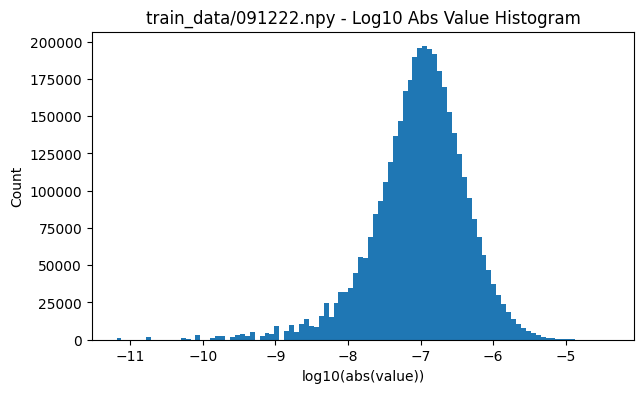

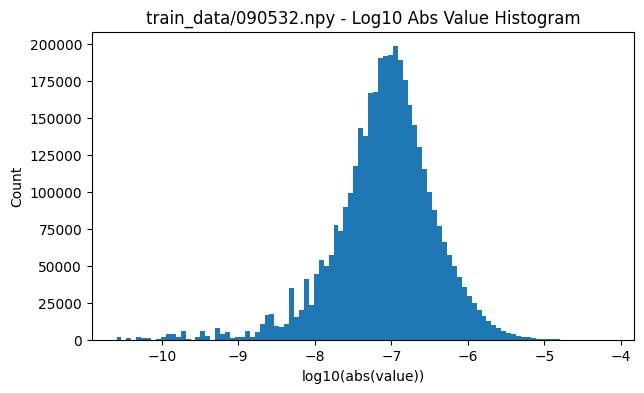

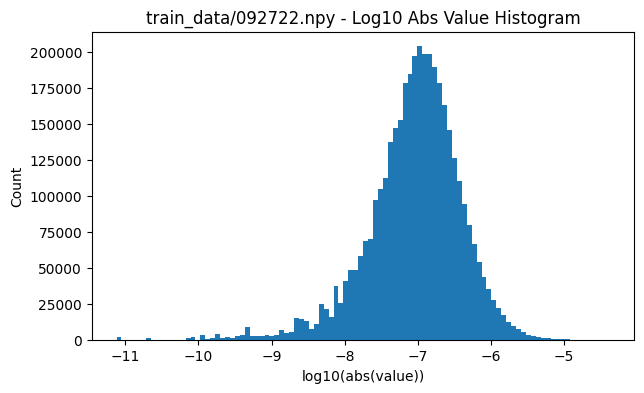

In [5]:
for k, v in results_dict.items():
    base_df = v['base_df']
    arr = base_df.values.flatten()
    arr_abs = np.abs(arr) + 1e-12
    plt.figure(figsize=(7, 4))
    plt.hist(np.log10(arr_abs), bins=100)
    plt.title(f"{k} - Log10 Abs Value Histogram")
    plt.xlabel("log10(abs(value))")
    plt.ylabel("Count")
    plt.show()

## Frequency analysis

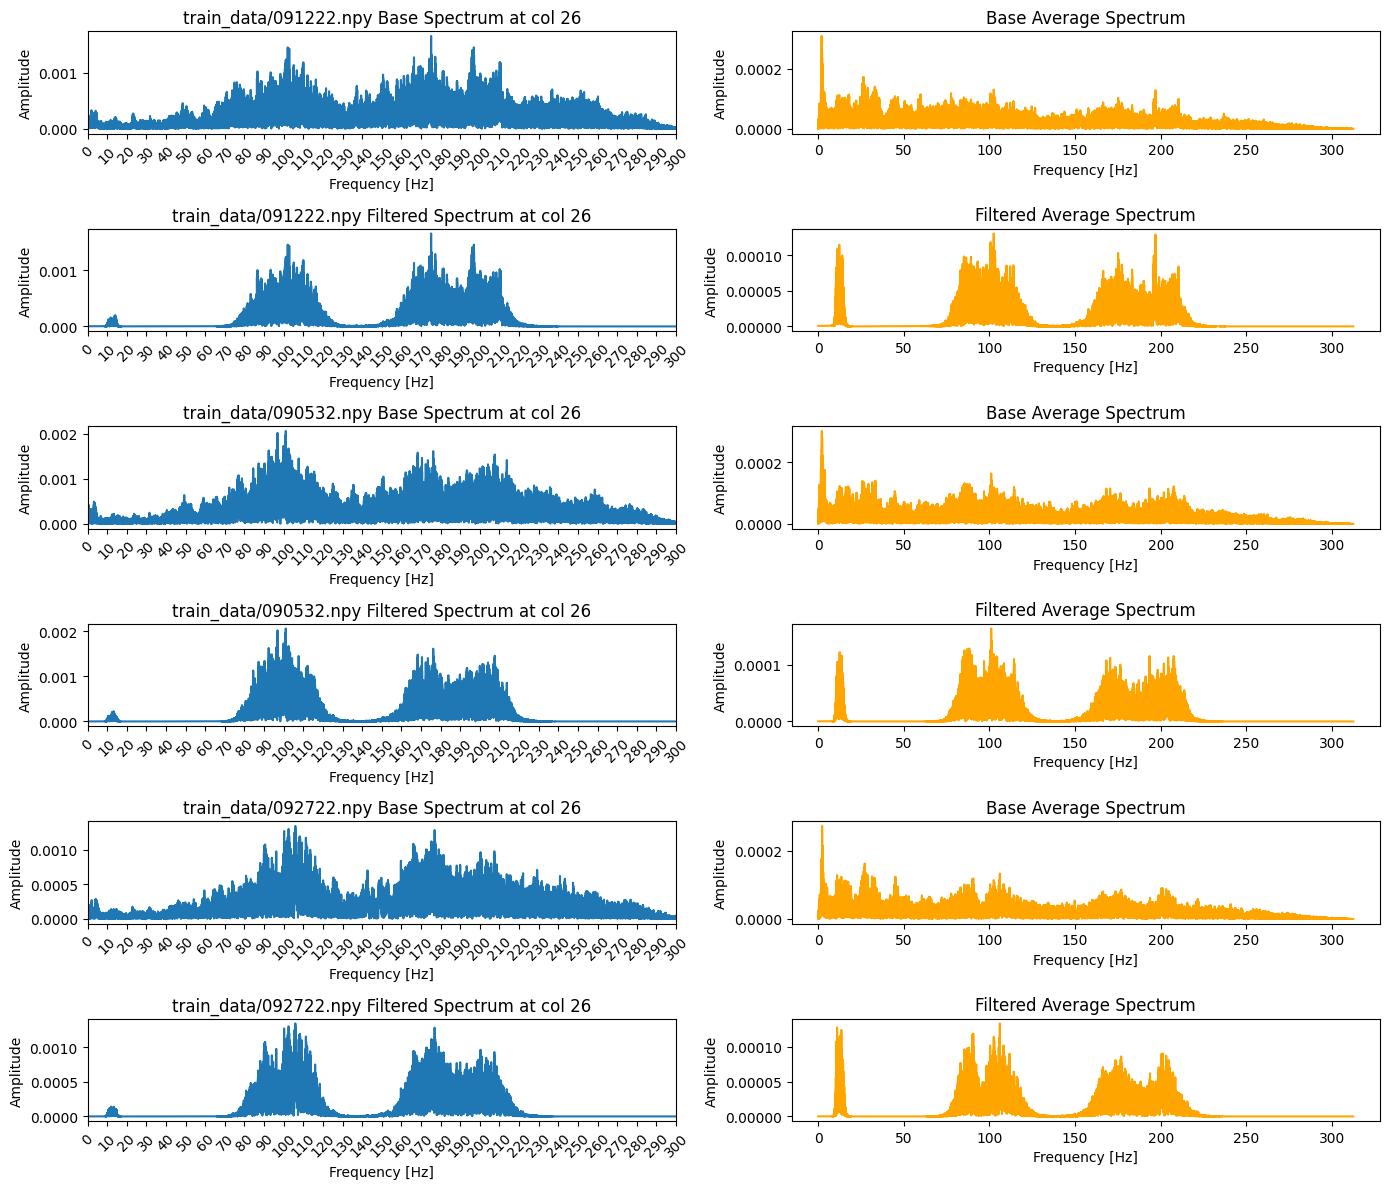

In [6]:
col_id_to_inspect = 26

num_files = len(results_dict)

fig, axes = plt.subplots(num_files*2, 2, figsize=(14, 4 * num_files))

for i, (fname, res) in enumerate(results_dict.items()):
    base_df = res['base_df']
    filtered_df = res['filtered_df']

    plot_fft(base_df, col_id_to_inspect, CONFIG['dt'], ax=axes[2*i, 0])
    axes[2*i, 0].set_title(f"{fname} Base Spectrum at col {col_id_to_inspect}")
    plot_average_freq_spectrum(
        base_df, CONFIG['dt'], ax=axes[2*i, 1])
    axes[2*i, 1].set_title("Base Average Spectrum")

    plot_fft(filtered_df, col_id_to_inspect, CONFIG['dt'], ax=axes[2*i+1, 0])
    axes[2*i+1,
         0].set_title(f"{fname} Filtered Spectrum at col {col_id_to_inspect}")
    plot_average_freq_spectrum(
        filtered_df, CONFIG['dt'], ax=axes[2*i+1, 1])
    axes[2*i+1, 1].set_title("Filtered Average Spectrum")

plt.tight_layout()
plt.show()

## Intermediate Results

### Image plots
- not preprocessed, unfiltered
- not preprocessed, filtered
- preprocessed, unfiltered
- preprocessed, filtered

![Base unfiltered](base_unfiltered.png)

![Base filtered](base_filtered.png)

![preprocessed unfiltered](pp_unfiltered.png)

![preprocessed filtered](pp_filtered.png)

## Edges (thresholding)

Example preprocessed image, with values grouped into bins.

![Edges bins](edges_bins.png)


## Detected lines

I selected parameters for the Hough Lines algo by creating plots with different combinations of params:

Example plot of this type:
![Hough params](hough_param_selection.png)



Example of lines detected, before merging

![Horizontal lines](horizontal_lines.png)


## Results

In this step I filter out lines with very low or very high speed and plot the final results.

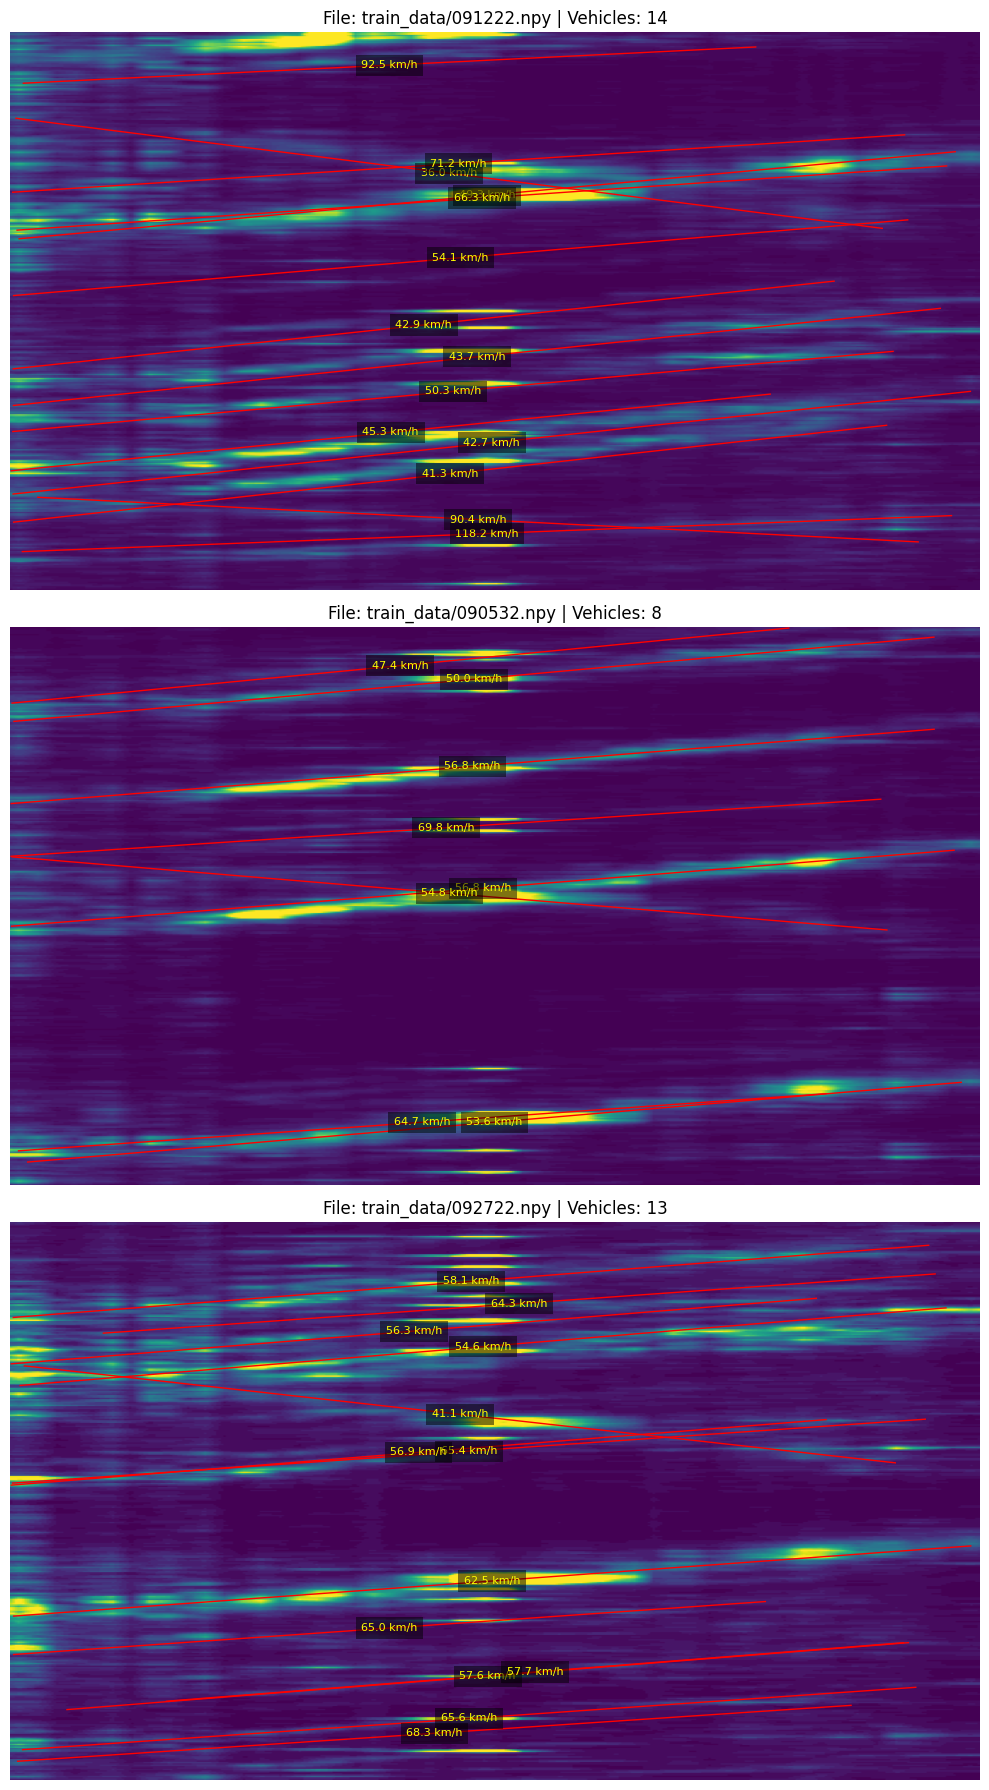

In [7]:
fig, axes = plt.subplots(num_files, 1, figsize=(10, 6 * num_files))

for i, (fname, res) in enumerate(results_dict.items()):

    processed_df = res['processed_df']
    merged_lines = res['merged_lines']
    speeds = res['speeds']

    if len(speeds) > 0:
        mask = (~np.isnan(speeds)) & (speeds <= 140) & (speeds > 15)
        merged_lines = merged_lines[mask]
        speeds = speeds[mask]
    ax = axes[i]
    low, high = np.percentile(processed_df, [3, 99])
    norm = Normalize(vmin=low, vmax=high, clip=True)

    plot_hough_lines(
        processed_df.to_numpy(), merged_lines, speeds, norm,
        title=f"File: {fname} | Vehicles: {len(speeds)}",
        ax=ax
    )

plt.tight_layout()
plt.show()

# Summary

## Mistakes I made:

- normalizing (with casting to int) before resizing, which caused all the floating points to get lost and the lines were very jagged.
- starting with too much preprocessing
- not starting with probabilistic Hough Lines (normal version instead)
- too agressive filtering with Fourier
- using binary "edges", bins work better as far as I'm correct
- using aggressive blurs/smoothing filters - they made it hard for line detection to create uniform line groups
- trying too hard with morphological operations

## Techniques I've tried: 

- Selecting frequency bands to filter out based on the peaks in the current spatial channel - maybe I made mistakes, but I couldn't find a proper cutoff point to make it work.
- Wavelet transform instead of Fourier - I tried using the implementation from skimage and it was very gentle with the frequencies, didn't filter out a lot no matter which function/mode I selected.
- Canny instead of thresholding, it struggled with wide lines and I couldn't get it to make continuous edges (maybe better filtering would help with that).
- Gaussian, Median, Bilateral filtering - the first 2 just amplified noise as far as I could tell, the last one made the more established lines way easier to notice visually, but smoothed out the small lines too much.
- Histogram equalization (cv2.equalizeHist and CLAHE), it amplified the lines very well but also amplified a lot of the noise and overall I found that it hurts my line detection.


## Flowchart

![Flowchart](DAS_diagram.png)

### References, inspirations etc

https://www.geeksforgeeks.org/data-science/signal-filtering-with-scipy/

https://docs.opencv.org/3.2.0/d1/dee/tutorial_moprh_lines_detection.html

https://stackoverflow.com/questions/71425968/remove-horizontal-lines-with-open-cv

https://numpy.org/doc/stable/reference/generated/numpy.digitize.html

https://docs.opencv.org/3.4/dc/dd3/tutorial_gausian_median_blur_bilateral_filter.html

https://scikit-image.org/docs/0.25.x/auto_examples/edges/plot_line_hough_transform.html

https://learnopencv.com/hough-transform-with-opencv-c-python/

https://matplotlib.org/stable/tutorials/images.html

https://stackoverflow.com/questions/69383018/best-way-to-downsample-reduce-sample-rate-non-time-series-data-in-pandas

https://dsp.stackexchange.com/questions/50664/denoising-a-signal

https://www.youtube.com/watch?v=s2K1JfNR7Sc

https://scikit-image.org/docs/0.25.x/auto_examples/filters/plot_denoise.html
